In [1]:
import mxnet as mx
from mxnet import gluon as g
from mxnet import nd
import numpy as np
from mxnet import autograd as ag
from matplotlib import pyplot as plt
import os
import time

In [2]:
ctx = mx.gpu()

In [3]:
batch_size = 512
height = 24
width = 7*height

In [4]:
data_iter = mx.io.ImageRecordIter(path_imglist=os.path.join('dataset','train.lst'), path_imgrec=os.path.join('dataset','train.rec'), data_shape=(3,height,width),
                                           shuffle=True, mean_r=123.68, mean_g=116.28, mean_b=103.53,
                                           std_r=58.395, std_g=57.12, std_b=57.375,
                                           batch_size=batch_size)

data_iter_val = mx.io.ImageRecordIter(path_imglist=os.path.join('dataset','val.lst'), path_imgrec=os.path.join('dataset','val.rec'), data_shape=(3,height,width),
                                           shuffle=True, mean_r=123.68, mean_g=116.28, mean_b=103.53,
                                           std_r=58.395, std_g=57.12, std_b=57.375,
                                           batch_size=batch_size)

### training

In [5]:
class autoencoder(g.nn.Block):
    def __init__(self):
        super(autoencoder, self).__init__()
        with self.name_scope():       
            self.encodercnn = g.nn.HybridSequential('encoder_cnn_')
            with self.encodercnn.name_scope():
                self.encodercnn.add(g.nn.Conv2D(64, 3, strides=1, padding=1, activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,2), strides=2))
                self.encodercnn.add(g.nn.Conv2D(128, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,2), strides=2))
                self.encodercnn.add(g.nn.Conv2D(256, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.Conv2D(256, 3, strides=1, padding=1,activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,1), strides=2))
                self.encodercnn.add(g.nn.Conv2D(512, 3, strides=1, padding=1))
                self.encodercnn.add(g.nn.BatchNorm(axis=1, center=True, scale=True))
                self.encodercnn.add(g.nn.Activation(activation='relu'))
                self.encodercnn.add(g.nn.Conv2D(512, 3, strides=1, padding=1))
                self.encodercnn.add(g.nn.BatchNorm(axis=1, center=True, scale=True))
                self.encodercnn.add(g.nn.Activation(activation='relu'))
                self.encodercnn.add(g.nn.MaxPool2D(pool_size=(2,1), strides=2))
                self.encodercnn.add(g.nn.Conv2D(512, 1, strides=1, padding=0,activation='relu'))
            
            self.encoderrnn = g.rnn.SequentialRNNCell('encoder_rnn_')
            with self.encoderrnn.name_scope():
                self.encoderrnn.add(g.rnn.LSTMCell(512))
                self.encoderrnn.add(g.rnn.LSTMCell(512))
            
            self.intermediate_nn = g.nn.Dense(512)
            #self.intermediate_nn1 = g.nn.Dense(512,activation='sigmoid')
            #self.intermediate_nn2 = g.nn.Dense(256,activation='sigmoid')
            #self.intermediate_nn3 = g.nn.Dense(512,activation='sigmoid')
            
            self.decoderrnn = g.rnn.SequentialRNNCell('decoder_rnn_')
            with self.decoderrnn.name_scope():
                self.decoderrnn.add(g.rnn.LSTMCell(512))
                self.decoderrnn.add(g.rnn.LSTMCell(512))
                
            self.decodercnn = g.nn.HybridSequential('decoder_cnn_')
            with self.decodercnn.name_scope():
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 1, strides=1, padding=0,activation='relu'))
                # upsampling (1,7)
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 3, strides=1, padding=1, activation='relu'))
                self.decodercnn.add(g.nn.Conv2DTranspose(512, 3, strides=1, padding=1, activation='relu'))
                # upsampling (2,14)
                self.decodercnn.add(g.nn.Conv2DTranspose(256, 3, strides=1, padding=1,activation='relu'))
                self.decodercnn.add(g.nn.Conv2DTranspose(256, 3, strides=1, padding=1,activation='relu'))
                # upsampling (4,28)
                self.decodercnn.add(g.nn.Conv2DTranspose(128, 3, strides=1, padding=1,activation='relu'))
                # upsampling (8,56)
                self.decodercnn.add(g.nn.Conv2DTranspose(64, 3, strides=1, padding=1, activation='relu'))
                # upsampling (16,112)
                self.decodercnn.add(g.nn.Conv2DTranspose(3, 3, strides=1, padding=1, activation='tanh'))
    def forward(self, x):
        # encoder
        x = self.encodercnn(x)
        status = self.encoderrnn.begin_state(batch_size=batch_size,ctx=ctx)
        for i in range(x.shape[3]):
            cvector, status = self.encoderrnn(nd.flatten(x[:,:,:,i]), status)
        cvector = self.intermediate_nn(cvector)
        #cvector = self.intermediate_nn1(cvector)
        #cvector = self.intermediate_nn2(cvector)
        #cvector = self.intermediate_nn3(cvector)
        # decoder
        for i in range(x.shape[3]):
            cvector, status = self.decoderrnn(cvector, status)
            if i == 0:
                outputs = mx.nd.expand_dims(cvector, axis=2)
            else:
                outputs = mx.nd.concat(outputs,mx.nd.expand_dims(cvector, axis=2),dim=2)
        xs = mx.nd.Reshape(outputs,(x.shape[0],x.shape[1],1,x.shape[3]))
        for i in range(len(self.decodercnn)):
            xs = self.decodercnn[i](xs)
            if (i == 0):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=2, width=2*7)
            elif (i == 2):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=3, width=3*7)
            elif (i == 4):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=6, width=6*7)
            elif (i == 5):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=12, width=12*7)
            elif (i == 6):
                xs = mx.nd.contrib.BilinearResize2D(xs, height=24, width=24*7)
        return xs*4

### Initialization for Optimization & Training

In [6]:
model = autoencoder()
model.hybridize()
model.collect_params().initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
for batch in data_iter:
    batch
    break
print(model(batch.data[0].as_in_context(ctx)).shape)
model.save_parameters('process/ae_*.params')

(512L, 3L, 24L, 168L)


In [7]:
criterion = g.loss.L2Loss()

### Optimization & Training

In [8]:
sd = 0.75
mean = 2
import scipy.stats
train_metric = mx.metric.MAE()
val_metric = mx.metric.MAE()
#for mean in range(0,5):
#for opt in sorted({'Adam','RMSProp','SGD'}):
for opt in sorted({'Adam'}):
#    for lr in sorted({0.1,0.01,0.001},reverse=True):
    for lr in sorted({0.01},reverse=True):
        epoch = 0
        epochs = 50
        model.load_parameters('process/ae_*.params')
        optimizer = g.Trainer(model.collect_params(), opt, {'learning_rate': lr, 'wd': 1e-5})
        print('### mean = %d ### Optimizer: %s ### Learning Rate: %.3f' % (mean,opt,lr))
        val_val_check = np.inf
        while epoch < epochs:
        #for epoch in range(start_epoch, epochs):
            # train
            train_loss = 0
            train_metric.reset()
            data_iter.reset()
            tic = time.time()
            counter = 0
            for batch in data_iter:
                with ag.record():
                    x = batch.data[0].as_in_context(ctx)
                    y = model(x)
                    #alpha = mx.nd.array(1-abs(1-(2*(1-scipy.stats.norm(mean*0.5, sd).cdf(batch.label[0].asnumpy())))),ctx=ctx)
                    #alpha = mx.nd.array(1*(batch.label[0].asnumpy() == 2),ctx=ctx)
                    alpha = 1
                    loss = alpha*criterion(x,y)
                    loss.backward()
                    train_loss += mx.nd.sum(loss).asscalar()
                optimizer.step(batch_size, ignore_stale_grad=True)
                train_metric.update(x, y)
                counter += 1
            toc = time.time()
            name_train, val_train = train_metric.get()
            # validation
            val_loss = 0
            val_metric.reset()
            data_iter_val.reset()
            for batch in data_iter_val:
                x = batch.data[0].as_in_context(ctx)
                y = model(x)
                loss = criterion(x,y)
                val_loss += mx.nd.sum(loss).asscalar()
                val_metric.update(x, y)
            name_val, val_val = val_metric.get()
            print('epoch:%3d;\t train:%.6e;%.6e;val:%.6e;%.6e;\t Speed:%d'
                  %(epoch, train_loss/(counter*batch_size), val_train, val_loss/(counter*batch_size), val_val, (counter*batch_size)/(toc-tic)))
            if val_val < val_val_check:
                model.save_parameters('process/ae_*.params')
                val_val_check = val_val
            epoch = epoch + 1

### mean = 2 ### Optimizer: Adam ### Learning Rate: 0.010
epoch:  0;	 train:3.760272e+00;2.455972e+00;val:4.066884e-01;2.429125e+00;	 Speed:465
epoch:  1;	 train:3.789403e+00;2.466380e+00;val:3.863856e-01;2.429190e+00;	 Speed:477
epoch:  2;	 train:3.787291e+00;2.465998e+00;val:4.090249e-01;2.429147e+00;	 Speed:477
epoch:  3;	 train:3.789397e+00;2.466380e+00;val:3.863646e-01;2.429150e+00;	 Speed:477
epoch:  4;	 train:3.789396e+00;2.466379e+00;val:4.067264e-01;2.429195e+00;	 Speed:477
epoch:  5;	 train:3.787325e+00;2.466005e+00;val:3.885528e-01;2.429112e+00;	 Speed:477
epoch:  6;	 train:3.789403e+00;2.466381e+00;val:4.066984e-01;2.429136e+00;	 Speed:477
epoch:  7;	 train:3.789356e+00;2.466371e+00;val:3.863787e-01;2.429179e+00;	 Speed:478
epoch:  8;	 train:3.787332e+00;2.466006e+00;val:4.090579e-01;2.429209e+00;	 Speed:478
epoch:  9;	 train:3.789424e+00;2.466386e+00;val:3.863636e-01;2.429145e+00;	 Speed:478
epoch: 10;	 train:3.789370e+00;2.466373e+00;val:4.066684e-01;2.429094e+00;	 Speed:

### Visualization

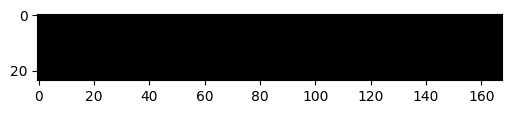

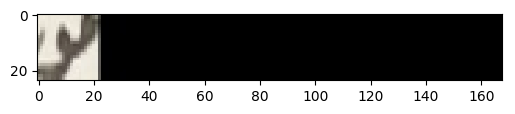

In [9]:
from random import randint
whichIm = randint(0,200)
for batch in data_iter_val:
    x = batch.data[0].as_in_context(ctx)
    y = model(x)
    break
val_image = y[whichIm,:,:,:].as_in_context(mx.cpu())
val_image = val_image.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
val_image = (val_image * 255).clip(0, 255)
val_image = val_image.asnumpy()
val_image = val_image.astype(np.uint8)
plt.rcParams["figure.dpi"] = 100
plt.imshow(val_image)
plt.savefig('val.png')
plt.show()
org = x[whichIm,:,:,:].as_in_context(mx.cpu())
org = org.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
org = (org * 255).clip(0, 255)
org = org.asnumpy()
org = org.astype(np.uint8)
plt.imshow(org)
plt.savefig('org.png')
plt.show()

In [10]:
from random import randint
whichIm = randint(0,200)
for batch in data_iter_val:
    x = batch.data[0].as_in_context(ctx)
    y = model(x)